In [1]:
import numpy as np
import matplotlib.pyplot as pl
from numba import jit
import xarray as xr
import moduphasespace

In [2]:
data = xr.open_dataset('../Jupyter/large_scale/data/caf_ls_eth_scipy.nc')
convective_area_fraction = data.convective_area_fraction.values
nb_cells = data.o_number.values
mean_area_convective_cells =  data.o_area.values

In [3]:
# def compute_phase_space(x_in, y_in, x_out, y_out):
#     dx = np.abs(x_out[2] - x_out[1])
#     dy = np.abs(y_out[2] - y_out[1])
#     ny, nx = len(y_out), len(x_out)
#     phase = np.zeros((ny, nx), dtype=np.int32)
    
#     for j in range(ny):
#         for i in range(nx):
#             pos = ((x_in >= x_out[i] - dx / 2) &
#                    (x_in < x_out[i] + dx / 2) &
#                    (y_in >= y_out[j] - dy / 2) &
#                    (y_in < y_out[j] + dy / 2))
            
#             if np.sum(pos) == 0:
#                 continue
            
#             phase[j, i] = np.sum(pos)
            
#     return phase

In [4]:
# def compute_phase_space_3d(x_in, y_in, x_out, y_out, arr):
#     dx = np.abs(x_out[2] - x_out[1])
#     dy = np.abs(y_out[2] - y_out[1])
#     ny, nx = len(y_out), len(x_out)
#     phase = np.zeros((ny, nx)) + np.NaN
    
#     if x_in.shape != y_in.shape or x_in.shape != arr.shape:
#         raise ValueError('Wrong dimensions.')
    
#     for j in range(ny):
#         for i in range(nx):
#             pos = ((x_in >= x_out[i] - dx / 2) &
#                    (x_in < x_out[i] + dx / 2) &
#                    (y_in >= y_out[j] - dy / 2) &
#                    (y_in < y_out[j] + dy / 2))
            
#             if np.sum(pos) == 0:
#                 continue
            
#             phase[j, i] = np.nanmean(arr[pos])
            
#     return np.ma.masked_invalid(phase)

In [5]:
def get_phasespace(x, y, z=None, *, bins=10, range=None, kind='mean'):
    try:
        len(bins)
        N0 = bins[0]
        N1 = bins[1]
    except TypeError:
        N0 = bins
        N1 = bins
        
    if z is not None:
        if np.isnan(z).any():
            raise ValueError("z contains NaN values.")
        
    if x.shape != y.shape:
        raise ValueError("Wrong dimensions.")
        if z is not None and (z.shape != x.shape):
            raise ValueError("z-array doesn't have the same dimensions.")
    if len(x.shape) != 1:
        raise ValueError(f"Not a 1D array, x.shape = {x.shape}")
        
    if range is None:
        if np.isnan(x).any() or np.isnan(y).any():
            raise ValueError("autodetected range of [nan, nan] is not finite")
        xout = np.linspace(x.min(), x.max(), N0)
        yout = np.linspace(y.min(), y.max(), N1)
    else:
        xout = np.linspace(range[0][0], range[0][1], N0)
        yout = np.linspace(range[1][0], range[1][1], N1)

    if z is None:
        phase = phasespace.phase_space_count(x, y, xout, yout)    
    else:
        if kind == 'mean':
            phase = phasespace.phase_space_avg(x, y, z, xout, yout)    
        elif kind == 'var':
            phase = np.ma.masked_equal(phasespace.phase_space_var(x, y, z, xout, yout), -9999)
    return  phase

In [6]:
pos = ~np.isnan(mean_area_convective_cells) & ~np.isnan(nb_cells) & ~np.isnan(convective_area_fraction)
xx = mean_area_convective_cells[pos].flatten()
yy = nb_cells[pos].flatten()
zz = convective_area_fraction[pos].flatten()

In [7]:
pha = get_phasespace(xx, yy, bins=[50, 10], range=[[0, 300], [0, 80]])

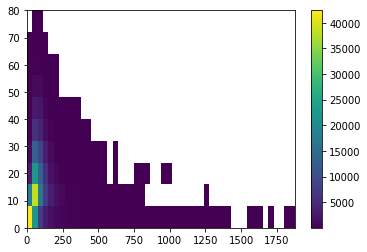

In [8]:
pl.imshow(np.ma.masked_equal(pha, 0), origin='ij', aspect='auto', extent=[0, 6.25*300, 0, 80])
pl.colorbar()

In [9]:
pha0 = get_phasespace(xx, yy, zz, bins=70, range=[[0, 300], [0, 80]])

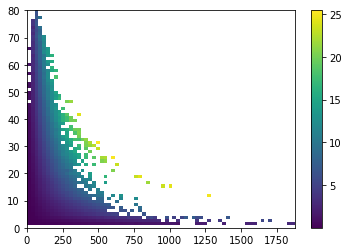

In [10]:
pl.imshow(100 * pha0, origin='ij', aspect='auto', extent=[0, 6.25*300, 0, 80])
pl.colorbar()

In [11]:
pha1 = get_phasespace(xx, yy, zz, bins=70, range=[[0, 300], [0, 80]], kind='var')

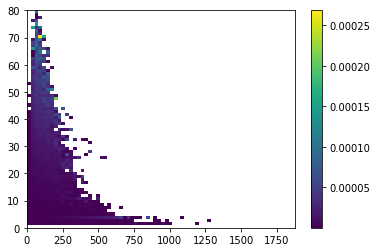

In [12]:
pl.imshow(pha1, origin='ij', aspect='auto', extent=[0, 6.25*300, 0, 80])
pl.colorbar()

/short/en0/vhl548/miniconda3/envs/radar/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


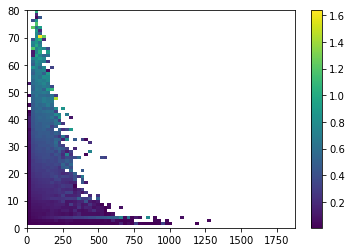

In [13]:
pl.imshow(100 * np.sqrt(pha1), origin='ij', aspect='auto', extent=[0, 6.25*300, 0, 80])
pl.colorbar()